In this lecture, we will give examples of using autoencoders for outlier detections. 

In [2]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os  
import re
import shutil
import string
import io
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredLogarithmicError

from IPython.display import Image
from IPython.core.display import HTML

%matplotlib inline

C:\Users\GAO\.conda\envs\gao_uat\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\GAO\.conda\envs\gao_uat\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\GAO\.conda\envs\gao_uat\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\GAO\.conda\envs\gao_uat\lib\site-packages\tensorboar

In [3]:
path="C:\\Users\\GAO\\python workspace\\GAO_Jupyter_Notebook\\Datasets"
os.chdir(path)

print(tf.__version__) # for TensorFlow 2.6 version, go to anaconda prompt and then delete the keras library (pip uninstall keras, see https://stackoverflow.com/questions/60269982/tensorflow-keras-alreadyexistserror)

2.7.0


### I. Using Simple Autoencoders for a Time Series Example

The first example involves using the ECG data. This dataset contains 5,000 Electrocardiograms, each with 140 data points. We will use a simplified version of the dataset, where each example has been labeled either 0 (corresponding to an abnormal rhythm), or 1 (corresponding to a normal rhythm). We are interested in identifying the abnormal rhythms. This example comes from the following sources:

   - http://www.timeseriesclassification.com/description.php?Dataset=ECG5000
   - https://www.tensorflow.org/tutorials/generative/autoencoder 

The dataset has 141 columns, the last of which indicates the label. Recall that an autoencoder is trained to minimize reconstruction error. We will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. We will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

In [5]:
#Image(url="https://miro.medium.com/max/3285/1*ZEvDcg1LP7xvrTSHt0B5-Q@2x.png", width=400, height=300)

In [5]:
df = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = df.values
print(type(raw_data))
df.head()

<class 'numpy.ndarray'>


,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [6]:
labels = raw_data[:, -1] # the last element contains the labels
data = raw_data[:, 0:-1] # the other data points are the electrocadriogram data

In [7]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=21)

min_val = tf.reduce_min(train_data) # computing minimum elements across dimensions of a tensor
max_val = tf.reduce_max(train_data)
print(min_val)
print(max_val)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32) # casting a tensor to a new type
test_data = tf.cast(test_data, tf.float32)


tf.Tensor(-6.2808752, shape=(), dtype=float64)
tf.Tensor(7.4021031, shape=(), dtype=float64)


We will train the autoencoder using only the normal rhythms, which are labeled in this dataset as 1. Let's separate the normal rhythms from the abnormal rhythms. And then let's look at the plots for each type.

In [8]:
train_labels = train_labels.astype(bool) # treating the label as boolean
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

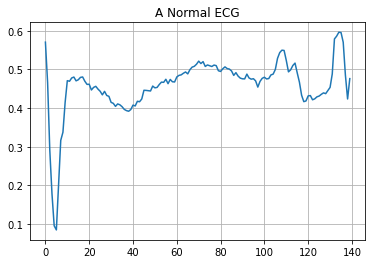

In [9]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

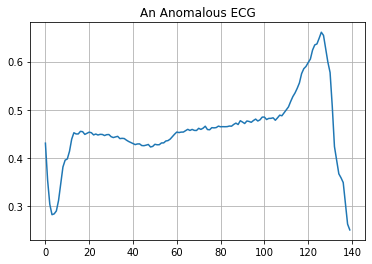

In [36]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

Now let's build a model using a Python class. Notice that the autoencoder is trained using only the normal ECGs, but is evaluated using the full test set:

In [10]:
class AnomalyDetector(Model):
  def __init__(self):
      
    super(AnomalyDetector, self).__init__()

    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [11]:
autoencoder.compile(optimizer='adam', loss='mae')

In [12]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=30, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/30
5/5 [==============================] - 1s 56ms/step - loss: 0.0580 - val_loss: 0.0537
Epoch 2/30
5/5 [==============================] - 0s 9ms/step - loss: 0.0568 - val_loss: 0.0526
Epoch 3/30
5/5 [==============================] - 0s 9ms/step - loss: 0.0553 - val_loss: 0.0514
Epoch 4/30
5/5 [==============================] - 0s 9ms/step - loss: 0.0532 - val_loss: 0.0501
Epoch 5/30
5/5 [==============================] - 0s 9ms/step - loss: 0.0505 - val_loss: 0.0487
Epoch 6/30
5/5 [==============================] - 0s 9ms/step - loss: 0.0472 - val_loss: 0.0473
Epoch 7/30
5/5 [==============================] - 0s 9ms/step - loss: 0.0437 - val_loss: 0.0455
Epoch 8/30
5/5 [==============================] - 0s 9ms/step - loss: 0.0402 - val_loss: 0.0432
Epoch 9/30
5/5 [==============================] - 0s 9ms/step - loss: 0.0368 - val_loss: 0.0416
Epoch 10/30
5/5 [==============================] - 0s 9ms/step - loss: 0.0338 - val_loss: 0.0402
Epoch 11/30
5/5 [=====================

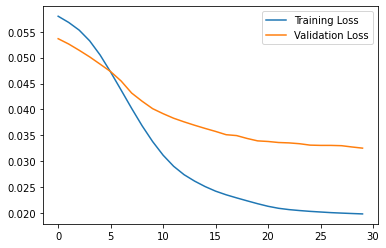

In [13]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

We will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error:

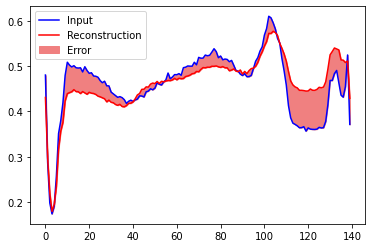

In [14]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Now let's create a similar plot, this time for an anomalous test example.

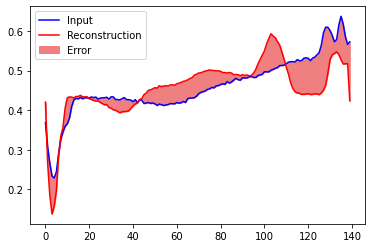

In [15]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

We now detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, we will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set. We will then plot the reconstruction error on normal ECGs from the training set.

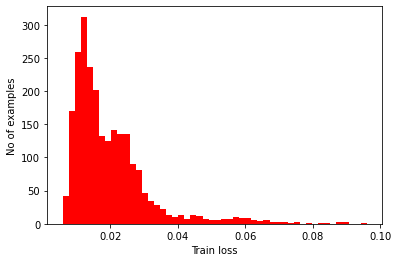

In [16]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50, color='red')
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

We will now choose a threshold value that is one standard deviations above the mean. If we examine the reconstruction error for the anomalous examples in the test set, we'll notice most have greater reconstruction error than the threshold. By varing the threshold, we can adjust the precision and recall of your classifier.

Threshold:  0.031599995


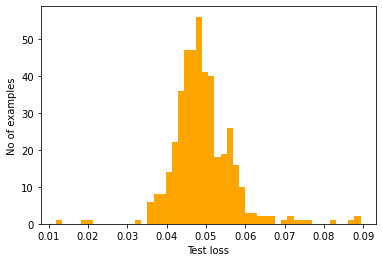

In [17]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50, color='orange')
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

We now classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [18]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [19]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.942
Precision = 0.9940944881889764
Recall = 0.9017857142857143


#### References: 

   - https://www.jeremyjordan.me/autoencoders/
   - https://www.jeremyjordan.me/variational-autoencoders/
   - https://www.analyticsvidhya.com/blog/2021/05/anomaly-detection-using-autoencoders-a-walk-through-in-python/
   - https://www.tensorflow.org/tutorials/generative/autoencoder  
   - http://www.timeseriesclassification.com/description.php?Dataset=ECG5000 